# Using glikonal in a real world setting

This notebook shows how to compute the minimal altitude for safe re-entry in an airfield, for gliding flight and in presence of obstacels, such as mountains.
Throughout the notebook we will use the airfield of Montricher (LSTR) as an example. However the same procedure can be applied to any other part of the world.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import glikonal

In [2]:
#the algorithm operates o a grid, with discrete indices. However we would like to use geographical coordinates to identify points on the grid. Hence we need a couple auxiliary functions to convert geographical coordinates into indices and vice versa
def coordinates_to_indices(longitude, latitude, lower_left_longitude, lower_left_latitude, upper_right_longitude,upper_right_latitude,H,W):
    """
    function to convert geographical coordinates to indices on a grid. 
    WARNING: this function will not work if the area of interest contains the 180th meridian
    """
    if(lower_left_longitude>upper_right_longitude):
        raise Exception('Right side is more east than left side')
    id_y=int((latitude-lower_left_latitude)*H/(upper_right_latitude-lower_left_latitude))
    id_x=int((longitude-lower_left_longitude)*W/(upper_right_longitude-lower_left_longitude))
    #print((longitude-lower_left_longitude)*H/(upper_right_longitude-lower_left_longitude))
    if(id_x>W or id_x<0):
        raise Exception("Index out of map bounds")
    if(id_y>H or id_y<0):
        raise Exception("Index out of map bounds")
    return id_x, id_y

def indices_to_coordinates(id_x,id_y, lower_left_longitude, lower_left_latitude, upper_right_longitude,upper_right_latitude,H,W):
    """
    Function to convert indices on a grid to geographical coordinates. 
    WARNING: this function will not work if the area of interest contains the 180th meridian.
    """
    latitude=lower_left_latitude+id_x/W*(upper_right_latitude-lower_left_latitude)
    longitude=lower_left_longitude+id_y/H*(upper_right_longitude-lower_left_longitude)
    return longitude,latitude

# Download topography data.
We will be using the free database AW3D30 created using the satellite .The database registers the elevation of points on earth every arcsecond of latitude (about 30 m) and longitude (about 30 m at the equator). For more information see 
(https://www.eorc.jaxa.jp/ALOS/en/dataset/aw3d30/aw3d30_e.htm)

The data for the surroundings of the LSTR airfield are already downloaded and they're placed in the same folder as this notebook under the name "output_AW3D30.tif". THerefore if you're only interested in this region you cqn disregard the procedure below.
1. Go to https://portal.opentopography.org/datasetMetadata?otCollectionID=OT.112016.4326.2, or go to https://opentopography.org/ search for "AW3D30" and click on the entry "ALOS World 3D - 30m".
2. In the section "Download and Access Products:" click on "AW3D30", this will open a new page
3. In the section "Coordinates" select "Manually select coordinates". This will allow us to download elevation data only for the rectangle of selected coordinates. For LSTR input the values 6,46,7,47  (in this order) in the four fields. then click "Validate coordinates and estimate area". This should show you the selected region in a map above. In the following we will refer to these four coordinted as respectively `ll_lon_tile`, `ll_lat_tile`, `ur_lon_tile`, `ur_lat_tile`, where `ll` stands for "lower left", `ur` stands for "upper right", "lat stands for "latitude" and "lon" stands for "longitude". These refer to the coordinates of the corners of the rectangle.
4. Select GeoTiff as data output format
5. Enter your email address and click on "Submit", this will send the request of the data and it will open a new page. After the process has completed download the zipped data. 
6. Unzip the data  (we will assume that the file is named "output_AW3D30.tif") and place then in the same folder as this notebook.
7. Run the next cells to load the data nito the program.

In [3]:
# Specify the file path to the DSM (Digital Surface Model) file
dsm_filename= "output_AW3D30.tif"
# Open the DSM file using rasterio
with rasterio.open(dsm_filename) as src:
    # Read the DSM data as a 2D NumPy array
    dsm_data = src.read(1)
# Print the shape and data type of the DSM array
print("DSM Shape:", dsm_data.shape)
print("DSM Data Type:", dsm_data.dtype)
dsm_data=dsm_data[::-1,:]
#use lower_left upper_right convention for coordinates


DSM Shape: (3600, 3600)
DSM Data Type: int16


### Select region of interest
The data we downloaded covers a region called a "tile", however we're interested in a smaller region inside the tile. In this cell, using the variables `ll_lon_tile`, `ll_lat_tile`, `ur_lon_tile`, `ur_lat_tile` we select the rectangle on which we run the algorithm. In the case of LSTR we select a region including the airport and part of the Jura mountain chain.

In [4]:
#data about the tile
H_tile,W_tile=dsm_data.shape
#the following coordinated should be matched with the ones of the downloaded tile.
ll_lon_tile=6 #longitude of the lower left corner of the tile
ll_lat_tile=46 #latitude of the lower left corner of the tile
ur_lon_tile=7 #longitude of the upper right corner of the tile
ur_lat_tile=47 #latitude of the upper right corner of the tile

#select portion of tile to run algorithm on
#these four coordinates select the portion of tile to consider
ll_lon=6
ll_lat=46.4
ur_lon=6.6
ur_lat=46.8
id_x_ll, id_y_ll=coordinates_to_indices(longitude=ll_lon, latitude=ll_lat, lower_left_longitude=ll_lon_tile, lower_left_latitude=ll_lat_tile, upper_right_longitude=ur_lon_tile,upper_right_latitude=ur_lat_tile,H=H_tile,W=W_tile)
id_x_ur, id_y_ur=coordinates_to_indices(longitude=ur_lon, latitude=ur_lat, lower_left_longitude=ll_lon_tile, lower_left_latitude=ll_lat_tile, upper_right_longitude=ur_lon_tile,upper_right_latitude=ur_lat_tile,H=H_tile,W=W_tile)
dsm_data_cropped=dsm_data[id_y_ll:id_y_ur,id_x_ll:id_x_ur]
# W,H are respectively the number of horizontal and vertical points in the selected region.
W=id_x_ur-id_x_ll 
H=id_y_ur-id_y_ll
print(f"Selected region: longitudes:[{ll_lon}, {ur_lon}] latitudes: [{ll_lat}, {ur_lat}].")
print(f"W={W}, H={H}") 

Selected region: longitudes:[6, 6.6] latitudes: [46.4, 46.8].
W=2159, H=1440


We now compute the scale of the map ,i.e., the correspondence between spacing on the grid and meters.
The data is collected taking a measure every arcsecond. When moving N-S the spacing between points is uniform in the map and is equal to 30.83 meters.
When moving E-W the length in meters of one arcsecond changes with the latitude: it is zero at the poles and 30.922 m at the equator. At intermediate latitudes it is computed below.
We will use a uniform scale across our selected region (i.e. we will pretend all of our selected region is found at the same latitude). This will imply that we'll make a small error in computing distances when going E-W.
The magnitude of this error (in percentage) is reported below. In most cases it will be smaler than 1%.

In [5]:
mean_latitude=(ll_lat+ur_lat)/2 #mean latitude of the map in degrees. This is used to compute the x scale of the map. The x scale is assumed to be uniform.
hx=30.922*np.cos(mean_latitude*np.pi/180) #meters corresponding to an arcsecond of longitude, at the latitude 'mean_latitude'
hy=30.83 #meters corresponding to an arcsecond of latitude

hx_max=30.922*np.cos(ll_lat*np.pi/180)
hx_min=30.922*np.cos(ur_lat*np.pi/180)
delta_h=np.maximum(np.abs(hx-hx_max),np.abs(hx-hx_min))
print(f"Maximal distance distortion from assuming uniform scale: {100*delta_h/hx:.4f}%")

x=np.linspace(0,W*hx,W)
y=np.linspace(0,H*hy,H)
xx,yy=np.meshgrid(x,y)
print(f"horizontal (E-W) spacing ={hx:.2f} m ")
print(f"vertical (N-S) spacing ={hy:.2f} m ")

Maximal distance distortion from assuming uniform scale: 0.3697%
horizontal (E-W) spacing =21.25 m 
vertical (N-S) spacing =30.83 m 


We are now ready to plot the elevation profile. 
In the case of LSTR the dark region in the bottom right is the Lac Léman, insted the brightest point in the middle is the top of Mont Tendre.

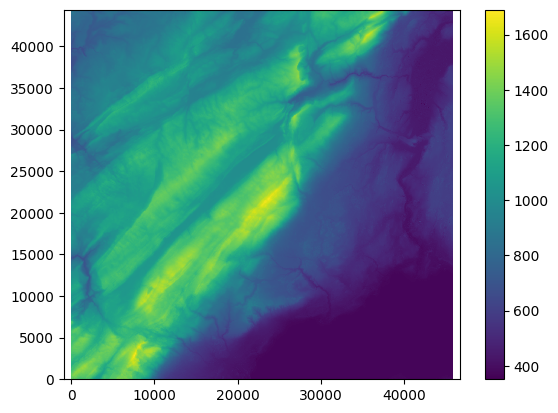

In [6]:
plt.figure()
plt.pcolormesh(xx,yy,dsm_data_cropped)
plt.axis('equal')
plt.colorbar()

In [7]:
def euclidean_distance_matrix(src_x,src_y,H,W,hx,hy):
    dist_mat=np.zeros([H,W])
    for x in range(W):
        for y in range(H):
            dist_mat[y,x]=np.sqrt(hx**2*(x-src_x)**2+hy**2*(y-src_y)**2)
    return dist_mat

## Glikonal solver

The following cell allows to set the parameters to run the algorithm.
1. `minimal_enroute_height` specifies the minimal height (AGL) in meters at which re-entry paths to the airport must keep at all points in the path. In other words the separation between re-entry paths and terrain must always be greater than this number.
2. `minimal_height_above_destination` is the minimal height (AGL) in meters at which I want to be when I reach the airfield.
3. `destination_lon`, `destination_lat` serve to specify respectively the longitude and latitude of the airfield. In this case the coordinates of LSTR are used.
4. `glide_ratio` is the glide ratio assumed by the algorithm.

In [8]:
minimal_enroute_height=300
minimal_height_above_destination=350
#coordinates for LSTR
destination_lon=6.40050
destination_lat=46.59040
glide_ratio=20 #assumed finesse

dest_id_x,dest_id_y=coordinates_to_indices(destination_lon, destination_lat, lower_left_longitude=ll_lon, lower_left_latitude=ll_lat, upper_right_longitude=ur_lon,upper_right_latitude=ur_lat,H=H,W=W)
init_value=dsm_data_cropped[dest_id_y,dest_id_x]+minimal_height_above_destination
elevation_corr=dsm_data_cropped+minimal_enroute_height
print(f"elevation at destination= {dsm_data_cropped[dest_id_y,dest_id_x]} m. Safety margin {minimal_height_above_destination} m")
print(f"enroute minimal height= {minimal_enroute_height} m. (at all points the gliding trajectory must be at least {minimal_enroute_height} m above the terrain)")

elevation at destination= 667 m. Safety margin 350 m
enroute minimal height= 300 m. (at all points the gliding trajectory must be at least 300 m above the terrain)


Now use the solver to compute the minimal altitude of the selected region.

In [9]:
origin_coords=(0,0,0)
# Instantiate EikonalSolver object using Cartesian coordinates.
solver = glikonal.EikonalSolver(coord_sys="cartesian")
# Set the coordinates of the lower bounds of the computational grid.
# For Cartesian coordinates this is x_min, y_min, z_min.
# In this example, the origin is the lower bound of the computation grid.
solver.velocity.min_coords = origin_coords
solver.elevation.min_coords = origin_coords

# Set the interval between nodes of the computational grid.
# For Cartesian coordinates this is dx, dy, dz.
# In this example the nodes are separated by 1 m in in each direction.
solver.velocity.node_intervals = hy, hx, 1
solver.elevation.node_intervals = hy, hx, 1

# Set the number of nodes in the computational grid.
# For Cartesian coordinates this is nx, ny, nz.
# This is a 2D example, so we only want one node in the z direction.
solver.velocity.npts = H,W, 1
solver.elevation.npts = H, W, 1

# Set the velocity model. In our case the velocity is just the glide ratio.
solver.velocity.values = glide_ratio*np.ones(solver.velocity.npts)

In [10]:
#set the elevation profile
solver.elevation.values[...,0] = elevation_corr
# Initialize the source. 
src_idx= dest_id_y,dest_id_x,0
# Set the altitude (traveltime) at the source node to 0.
solver.traveltime.values[src_idx] = init_value
# Set the unknown flag for the source node to False.
# This is an FMM state variable indicating which values are completely
# unknown. Setting it to False indicates that the node has a tentative value
# assigned to it. In this case, the tentative value happens to be the true,
# final value.
solver.unknown[src_idx] = False
# Push the index of the source node onto the narrow-band heap.
solver.trial.push(*src_idx)
# Solve the system.
solver.solve()

1


Before getting to the results here is a short reminder ofthe limitations of this algorithm. While in principle the result should be correct, one never knows.
### It is important to understand this is still a relatively new algorithm and there is no guarantee that all of its outputs are correct. Hence don't trust this thing blindly. Since this algorithm can be used in safety critical applications, let us report here the disclaimer also contained in the license file. 

15. Disclaimer of Warranty.
  THERE IS NO WARRANTY FOR THE PROGRAM, TO THE EXTENT PERMITTED BY
APPLICABLE LAW.  EXCEPT WHEN OTHERWISE STATED IN WRITING THE COPYRIGHT
HOLDERS AND/OR OTHER PARTIES PROVIDE THE PROGRAM "AS IS" WITHOUT WARRANTY
OF ANY KIND, EITHER EXPRESSED OR IMPLIED, INCLUDING, BUT NOT LIMITED TO,
THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR
PURPOSE.  THE ENTIRE RISK AS TO THE QUALITY AND PERFORMANCE OF THE PROGRAM
IS WITH YOU.  SHOULD THE PROGRAM PROVE DEFECTIVE, YOU ASSUME THE COST OF
ALL NECESSARY SERVICING, REPAIR OR CORRECTION.

  16. Limitation of Liability.
  IN NO EVENT UNLESS REQUIRED BY APPLICABLE LAW OR AGREED TO IN WRITING
WILL ANY COPYRIGHT HOLDER, OR ANY OTHER PARTY WHO MODIFIES AND/OR CONVEYS
THE PROGRAM AS PERMITTED ABOVE, BE LIABLE TO YOU FOR DAMAGES, INCLUDING ANY
GENERAL, SPECIAL, INCIDENTAL OR CONSEQUENTIAL DAMAGES ARISING OUT OF THE
USE OR INABILITY TO USE THE PROGRAM (INCLUDING BUT NOT LIMITED TO LOSS OF
DATA OR DATA BEING RENDERED INACCURATE OR LOSSES SUSTAINED BY YOU OR THIRD
PARTIES OR A FAILURE OF THE PROGRAM TO OPERATE WITH ANY OTHER PROGRAMS),
EVEN IF SUCH HOLDER OR OTHER PARTY HAS BEEN ADVISED OF THE POSSIBILITY OF
SUCH DAMAGES.

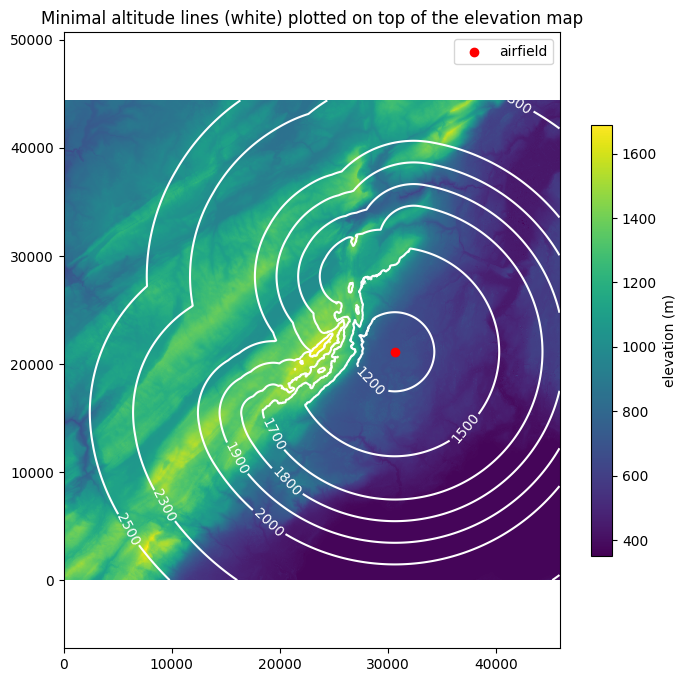

In [11]:
# And finally, get the traveltime values.
plt.figure(figsize=[8,8]) #adjust the two numbers in the brackets to control the dimensions of the figure.
plt.axis('equal')
#plt.pcolormesh(xx,yy,solver.traveltime.values[...,0])
plt.pcolormesh(xx,yy,dsm_data_cropped)
plt.colorbar(label="elevation (m)",shrink=0.7)
CS=plt.contour(xx,yy,solver.traveltime.values[...,0],levels=[1200,1500,1700,1800,1900,2000,2300,2500],colors='white',antialiased=True) #changing the numbers in the list one can look at other altitude levels.
plt.clabel(CS, CS.levels, inline=True, fontsize=10)
#plt.contour(solver.traveltime.values[...,0],levels=[20,40,60,80,100])
plt.scatter(dest_id_x*hx,dest_id_y*hy,color="red",label="airfield")
plt.legend()
plt.title("Minimal altitude lines (white) plotted on top of the elevation map");
#plt.savefig("pics/minimal_glide_altitude_lstr_elevation.png", bbox_inches='tight',dpi=150)


/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_55089/2784183802.py:8: RuntimeWarning: invalid value encountered in divide
  grad_V[0]=grad_V[0]/grad_norm
/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_55089/2784183802.py:9: RuntimeWarning: invalid value encountered in divide
  grad_V[1]=grad_V[1]/grad_norm


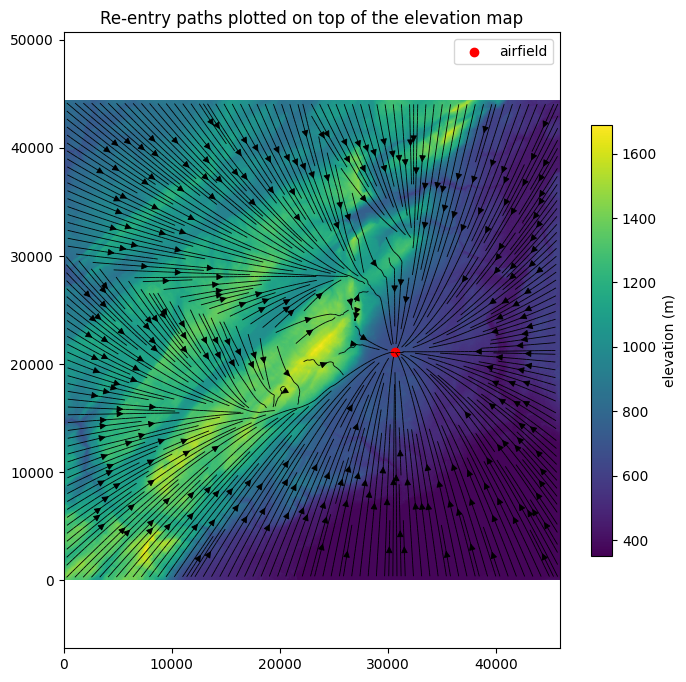

In [12]:
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.pcolormesh(xx,yy,dsm_data_cropped)
plt.colorbar(label="elevation (m)",shrink=0.7)
V=solver.traveltime.values[...,0]
grad_V=np.array(np.gradient(V))
grad_norm=np.sqrt(grad_V[0]**2+grad_V[1]**2)
grad_V[0]=grad_V[0]/grad_norm
grad_V[1]=grad_V[1]/grad_norm
plt.streamplot(xx,yy,-grad_V[1],-grad_V[0],start_points=None,integration_direction='forward',density=4,color="black",linewidth=0.6)
plt.title("Re-entry paths plotted on top of the elevation map");
plt.scatter(dest_id_x*hx,dest_id_y*hy,color="red",label="airfield")
plt.legend()

For the case of LSTR we already downloaded a picture of the selected area from openstreetmaps (OSM).
Plotting the contour lines on top of it gives more visual cues. 

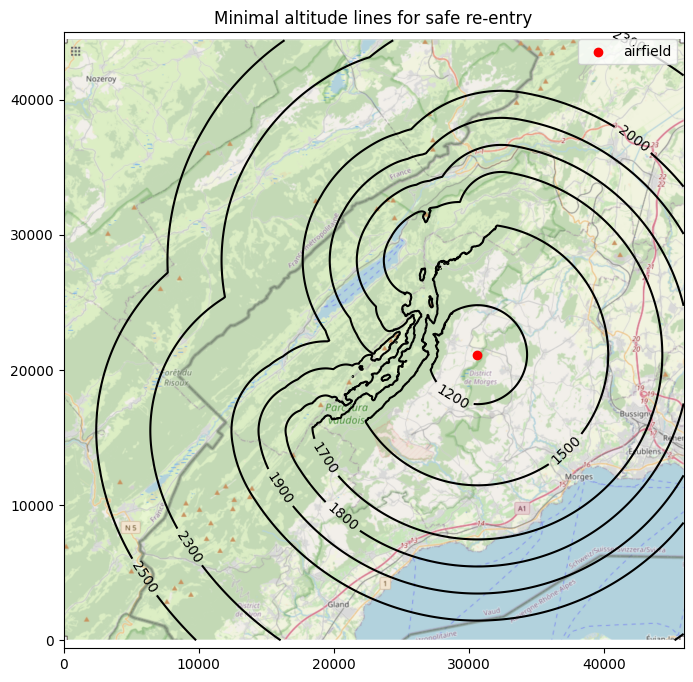

In [13]:
plt.figure(figsize=[8,8])
plt.axis('equal')
CS=plt.contour(xx,yy,solver.traveltime.values[...,0],levels=[1200,1500,1700,1800,1900,2000,2300,2500],colors='black',antialiased=True)
img=plt.imread("pics/osm_6_6.6E_46.4_46.8N.png")
plt.imshow(img,extent=[0,W*hx,0,H*hy])
plt.clabel(CS, CS.levels, inline=True, fontsize=10)
plt.scatter(dest_id_x*hx,dest_id_y*hy,color="red",label="airfield")
plt.legend()
plt.title("Minimal altitude lines for safe re-entry")
#plt.savefig("pics/minimal_glide_altitude_lstr_osm.png", bbox_inches='tight',dpi=150)

/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_55089/3352179819.py:6: RuntimeWarning: invalid value encountered in divide
  grad_V[0]=grad_V[0]/grad_norm
/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_55089/3352179819.py:7: RuntimeWarning: invalid value encountered in divide
  grad_V[1]=grad_V[1]/grad_norm


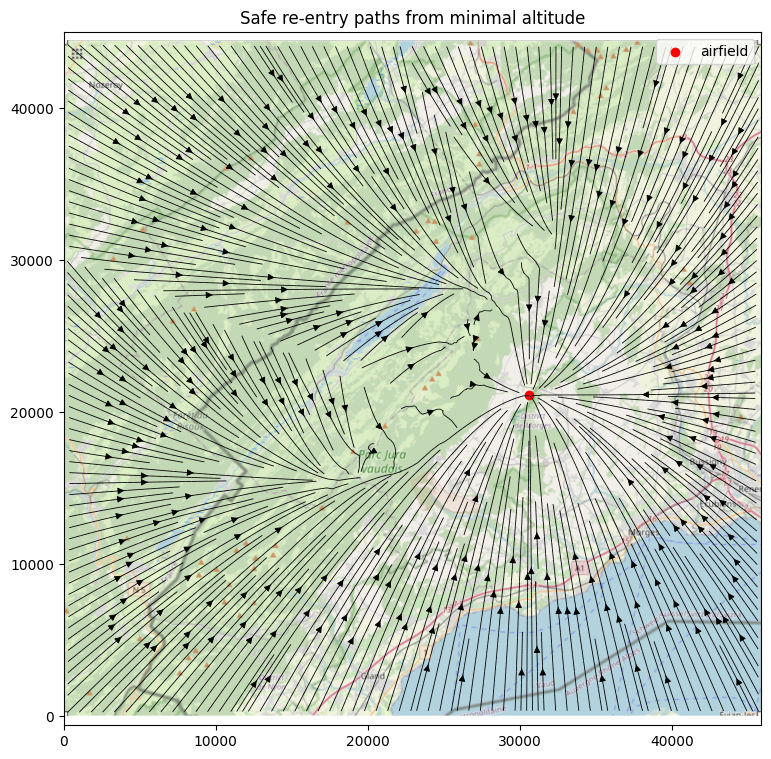

In [14]:
plt.figure(figsize=(9,9))
plt.axis('equal')
V=solver.traveltime.values[...,0]
grad_V=np.array(np.gradient(V))
grad_norm=np.sqrt(grad_V[0]**2+grad_V[1]**2)
grad_V[0]=grad_V[0]/grad_norm
grad_V[1]=grad_V[1]/grad_norm
plt.imshow(img,extent=[0,W*hx,0,H*hy])
plt.streamplot(xx,yy,-grad_V[1],-grad_V[0],start_points=None,integration_direction='forward',density=4,color='black',linewidth=0.6)
plt.scatter(dest_id_x*hx,dest_id_y*hy,color="red",label="airfield")
plt.legend()
plt.title("Safe re-entry paths from minimal altitude")
#plt.savefig("pics/re_entry_paths_lstr_osm.png", bbox_inches='tight',dpi=150)

## Verify solution in the cone regime 
In this last plot we check that at least in absence of mountains, the gliding cone and the solution of this algorithm coincide. THe lines of the gliding cone are in red, while the ones obtained by the glikonal algorithm are in black. One can see that the two sets of lines coincide perfectly on the plain, instead they differ on the mountainous side, exactly as it should be.

In [15]:
cone_solution=euclidean_distance_matrix(dest_id_x,dest_id_y,H,W,hx,hy)
cone_minimal_altitude=init_value+cone_solution/glide_ratio

<a list of 9 text.Text objects>

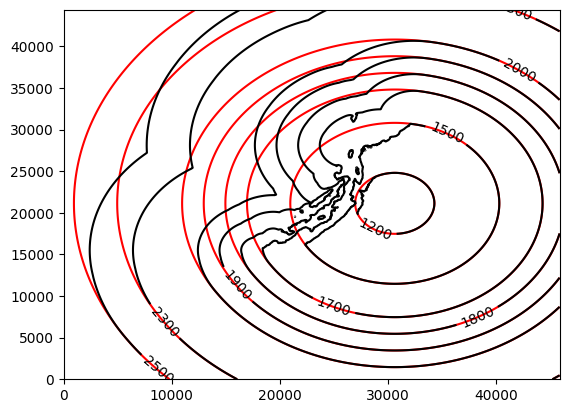

In [16]:
CS_euclid=plt.contour(xx,yy,cone_minimal_altitude,levels=[1200,1500,1700,1800,1900,2000,2300,2500],colors='red',antialiased=True)
CS=plt.contour(xx,yy,solver.traveltime.values[...,0],levels=[1200,1500,1700,1800,1900,2000,2300,2500],colors='black',antialiased=True)
plt.clabel(CS, CS.levels, inline=True, fontsize=10)